In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:
def load_data(file_path):
    """Loads the retrieval results from the JSON file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded {len(data)} queries from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON from {file_path}.")
        return None

In [3]:
def calculate_precision_at_k(retrieved_serials, ground_truth_set, k):
    """Calculates Precision@k."""
    if k == 0:
        return 0.0
    retrieved_at_k = set(retrieved_serials[:k])
    intersection = retrieved_at_k.intersection(ground_truth_set)
    return len(intersection) / k

In [4]:
def calculate_recall_at_k(retrieved_serials, ground_truth_set, k):
    """Calculates Recall@k."""
    if len(ground_truth_set) == 0:
        return 0.0  # Or 1.0, depending on definition, 0.0 is safer.
    retrieved_at_k = set(retrieved_serials[:k])
    intersection = retrieved_at_k.intersection(ground_truth_set)
    return len(intersection) / len(ground_truth_set)

In [5]:
def calculate_reciprocal_rank(retrieved_serials, ground_truth_set):
    """Calculates the Reciprocal Rank (RR) for a single query."""
    for i, serial in enumerate(retrieved_serials):
        if serial in ground_truth_set:
            return 1.0 / (i + 1)  # Rank is i+1
    return 0.0

In [6]:
def process_evaluation(data, max_k=10):
    """Processes all queries and calculates metrics."""
    all_scores = []

    for item in data:
        query = item['query']
        ground_truth_set = set(item['groundTruth'])
        retrieved_docs = item['retrieved']
        retrieved_serials = [doc['serialNumber'] for doc in retrieved_docs]

        query_scores = {'query': query}
        
        # Calculate P@k and R@k for k from 1 to max_k
        for k in range(1, max_k + 1):
            query_scores[f'p@{k}'] = calculate_precision_at_k(retrieved_serials, ground_truth_set, k)
            query_scores[f'r@{k}'] = calculate_recall_at_k(retrieved_serials, ground_truth_set, k)
        
        # Calculate Reciprocal Rank
        query_scores['rr'] = calculate_reciprocal_rank(retrieved_serials, ground_truth_set)
        
        all_scores.append(query_scores)
    
    return pd.DataFrame(all_scores)

In [7]:
def plot_metrics(df_mean, k_values):
    """Plots and saves the Precision@k and Recall@k curves."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, df_mean[[f'p@{k}' for k in k_values]].values, marker='o', label='Mean Precision@k')
    plt.plot(k_values, df_mean[[f'r@{k}' for k in k_values]].values, marker='x', label='Mean Recall@k')
    plt.title('Mean Precision & Recall vs. k', fontsize=16)
    plt.xlabel('k (Number of Retrieved Documents)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(k_values)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.tight_layout()
    plt.savefig('precision_recall_at_k_curve.png')
    print("Saved Precision_Recall_at_k_curve.png")

In [8]:
def plot_precision_recall_curve(df_mean, k_values):
    """Plots and saves the interpolated Precision-Recall curve."""
    mean_recall = df_mean[[f'r@{k}' for k in k_values]].values
    mean_precision = df_mean[[f'p@{k}' for k in k_values]].values
    
    # Add (0, 1) to the start for a proper curve shape if r@1 is not 0
    plot_recall = np.insert(mean_recall, 0, 0)
    plot_precision = np.insert(mean_precision, 0, mean_precision[0]) # Assume p@0 = p@1

    # Calculate Area Under Curve (AUC)
    pr_auc = auc(plot_recall, plot_precision)

    plt.figure(figsize=(8, 8))
    plt.plot(plot_recall, plot_precision, marker='o', label=f'Precision-Recall (AUC = {pr_auc:.3f})')
    plt.title('Mean Precision-Recall Curve', fontsize=16)
    plt.xlabel('Mean Recall', fontsize=12)
    plt.ylabel('Mean Precision', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.savefig('mean_precision_recall_curve.png')
    print("Saved mean_precision_recall_curve.png")

In [13]:
# --- Main Execution ---
def main():
    file_path = '../backend/src/testing/retrieval_results.json'
    data = load_data(file_path)
    
    if data:
        max_k = 10
        k_values = list(range(1, max_k + 1))
        
        # 1. Process data and get scores
        df_scores = process_evaluation(data, max_k)
        
        # 2. Calculate mean scores
        df_mean = df_scores.drop(columns=['query']).mean()
        
        # 3. Print final metrics for the paper
        print("\n--- Final Evaluation Metrics ---")
        print(f"Total Queries: {len(df_scores)}")
        print(f"Mean Precision@3: {df_mean['p@3']:.4f}")
        print(f"Mean Precision@5: {df_mean['p@5']:.4f}")
        print(f"Mean Precision@10: {df_mean['p@10']:.4f}")
        print("-" * 30)
        print(f"Mean Recall@3: {df_mean['r@3']:.4f}")
        print(f"Mean Recall@5: {df_mean['r@5']:.4f}")
        print(f"Mean Recall@10: {df_mean['r@10']:.4f}")
        print("-" * 30)
        print(f"Mean Reciprocal Rank (MRR)@10: {df_mean['rr']:.4f}")
        print("----------------------------------\n")
        
        # 4. Generate and save plots
        plot_metrics(df_mean, k_values)
        plot_precision_recall_curve(df_mean, k_values)
        
        # 5. Save detailed scores to CSV
        df_scores.to_csv('evaluation_scores_per_query.csv', index=False)
        df_mean.to_csv('evaluation_scores_mean.csv', header=False)
        print("Saved detailed scores to evaluation_scores_per_query.csv")
        print("Saved mean scores to evaluation_scores_mean.csv")

Successfully loaded 47 queries from ../backend/src/testing/retrieval_results.json

--- Final Evaluation Metrics ---
Total Queries: 47
Mean Precision@3: 0.7447
Mean Precision@5: 0.6085
Mean Precision@10: 0.3915
------------------------------
Mean Recall@3: 0.5923
Mean Recall@5: 0.7382
Mean Recall@10: 0.8434
------------------------------
Mean Reciprocal Rank (MRR)@10: 0.9433
----------------------------------

Saved Precision_Recall_at_k_curve.png
Saved mean_precision_recall_curve.png
Saved detailed scores to evaluation_scores_per_query.csv
Saved mean scores to evaluation_scores_mean.csv


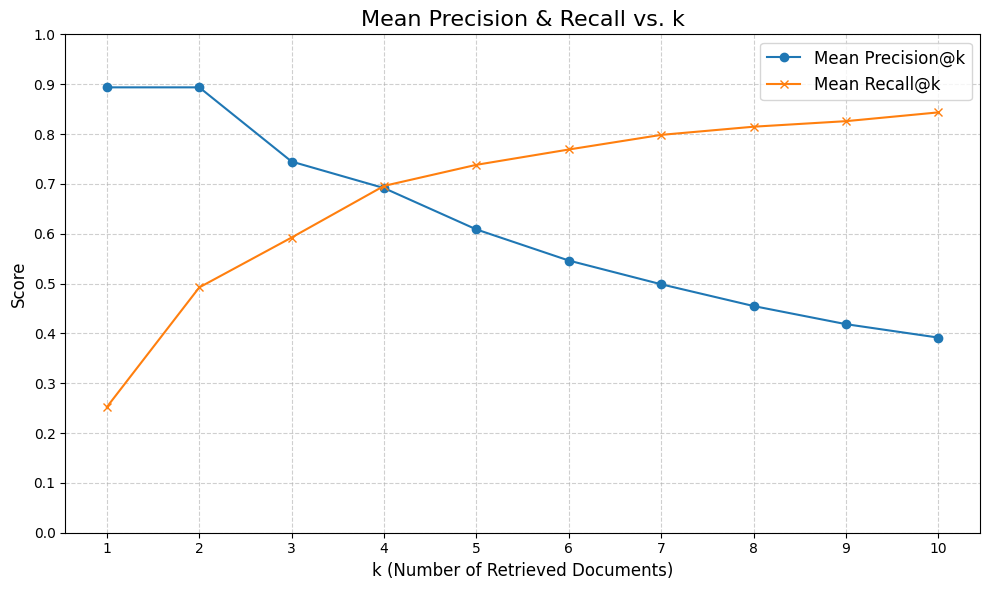

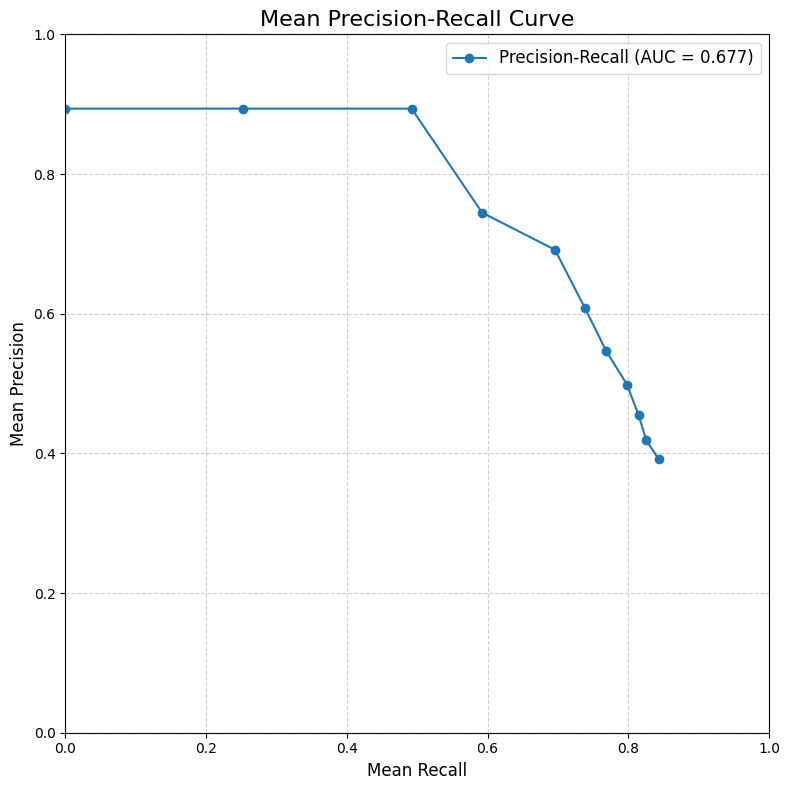

In [14]:
if __name__ == "__main__":
    main()